In [1]:
!pip install --upgrade PyMCubes
!pip install pycollada

     |████████████████████████████████| 266kB 10.6MB/s 
     |████████████████████████████████| 112kB 21.1MB/s 
  Created wheel for pycollada: filename=pycollada-0.7.1-cp36-none-any.whl size=125610 sha256=1de3d6e2b750130770a1ad17085aa4dcba9ab33fb92859b67aa5246b8b03ef13
  Stored in directory: /root/.cache/pip/wheels/b0/5d/2a/e6af10b1976334ef7bdea943abff28254b6431bca2b0f18bbc
Successfully built pycollada


In [2]:
import cv2
import numpy as np
from itertools import product
import torch.nn as nn
import torch
import collections
import mcubes

import os
from google.colab import drive
# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# create folder to write data to
FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'suzanne')
os.makedirs(FOLDER, exist_ok=True)

Mounted at /content/gdrive


In [3]:
data_dir = "gdrive/My Drive/VisualHull/suzanne/"
file_base = "suzanne"
T = 20

# Reading Images and Camera Parameters

In [4]:
with open(data_dir + "/" + "par.txt", 'r') as f:
  lines = f.readlines() 

  M_ALL = []
  for l in lines[1:]: 
    tmp = np.array(l.strip().split(" ")).astype(np.float32)
    M_ALL.append(tmp.reshape((3, 4)))

  N = len(lines) - 1

In [5]:
EXPERIMENT_INDICES = []

for i in range(N):
  EXPERIMENT_INDICES.append(np.linspace(0, N - 1, (i + 1)).astype(int).tolist())

In [13]:
print(M_ALL[0])

[[-8.783267e+02  0.000000e+00 -3.479448e+02  1.599999e+02]
 [-1.587451e+02 -1.000000e+03  1.800000e+02  1.200000e+02]
 [-6.614000e-01  0.000000e+00  7.500000e-01  5.000000e-01]]


In [14]:
# Reading images
imgs = []
kernel = np.ones((3,3), np.uint8) 
for i in range(N):
  im = cv2.imread(data_dir + "/" + file_base + "_" + str(i) + ".png", 0) / 255
  im = cv2.erode(im, kernel, iterations=1) 
  im = cv2.dilate(im, kernel, iterations=1) 
  _, im = cv2.threshold(im, 0.1, 1, cv2.THRESH_BINARY)
  imgs.append(np.array(im))
imgs = np.array(imgs)

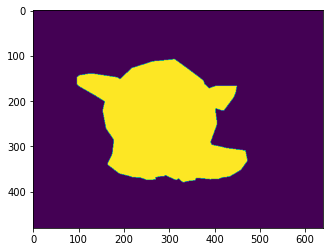

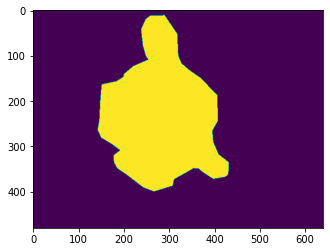

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(imgs[10])

In [16]:
# Thresholding images for masking
silhouettes_ALL = []
for im in imgs:
  silhouettes_ALL.append(im > 0)
silhouettes_ALL = np.array(silhouettes_ALL).transpose(1, 2, 0)

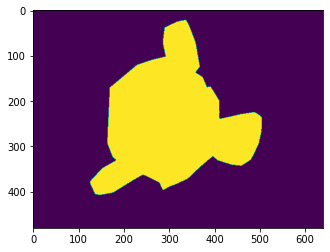

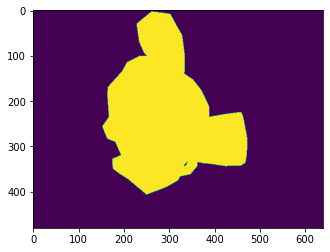

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(silhouettes_ALL[:, :, 2])
plt.figure()
plt.imshow(silhouettes_ALL[:, :, 46])

# Model

In [18]:
class DownsampleBlock(nn.Module):
  def __init__(self, in_channels, out_channels, size, stride=1):
    super(DownsampleBlock, self).__init__()
    self.net = nn.Sequential(collections.OrderedDict([  
                          ('conv1', nn.Conv3d(in_channels, out_channels, size)),  
                          ('downsample1', nn.AvgPool3d(2, stride=2)),  
                          ('bn1', nn.BatchNorm3d(out_channels)),  
                          ('relu1', nn.LeakyReLU()),
                           
                          ('conv2', nn.Conv3d(out_channels, out_channels, size)),  
                          ('bn2', nn.BatchNorm3d(out_channels)),  
                          ('relu2', nn.LeakyReLU())  
                        ]))
    
  def forward(self, x):
    return self.net(x)

In [19]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, out_channels, size, final=False):
    super(UpsampleBlock, self).__init__()
    
    if(final == False):
      self.net = nn.Sequential(collections.OrderedDict([
                            ('bn1', nn.BatchNorm3d(in_channels)),  
                          
                            ('conv2', nn.ConvTranspose3d(in_channels, out_channels, size)),  
                            ('bn2', nn.BatchNorm3d(out_channels)),  
                            ('relu2', nn.LeakyReLU()),

                            ('conv3', nn.ConvTranspose3d(out_channels, out_channels, size)),  
                            ('bn3', nn.BatchNorm3d(out_channels)),  
                            ('relu3', nn.LeakyReLU()), 
                              
                            ('upsample3', nn.Upsample(scale_factor=2))
                          ]))
    else:
      self.net = nn.Sequential(collections.OrderedDict([
                            ('bn1', nn.BatchNorm3d(in_channels)),  
                          
                            ('conv2', nn.ConvTranspose3d(in_channels, out_channels, size)),  
                            ('bn2', nn.BatchNorm3d(out_channels)),  
                            ('relu2', nn.LeakyReLU()),

                            ('conv3', nn.ConvTranspose3d(out_channels, out_channels, size)), 
                            ('bn3', nn.BatchNorm3d(out_channels))
                            # ('relu3', nn.LeakyReLU()), 
                              
                            # ('upsample3', nn.Upsample(scale_factor=2))
                          ]))
      
  def forward(self, x):
    return self.net(x)

In [20]:
class UNet3D(nn.Module):
  def __init__(self, input_channels):
    super(UNet3D, self).__init__()

    self.down_1 = DownsampleBlock(input_channels, 16, 3)
    self.down_2 = DownsampleBlock(16, 32, 3)
    # self.down_3 = DownsampleBlock(32, 64, 3)
    # self.down_4 = DownsampleBlock(64, 128, 3)
    # self.down_5 = DownsampleBlock(128, 128, 3)
    # self.down_6 = DownsampleBlock(128, 128, 3)
    
    self.up_1 = UpsampleBlock(16, input_channels, 5, final=True)
    self.up_2 = UpsampleBlock(32, 16, 3)
    # self.up_3 = UpsampleBlock(64, 32, 7)
    # self.up_4 = UpsampleBlock(128, 64, 5)
    # self.up_5 = UpsampleBlock(128, 128, 5)
    # self.up_6 = UpsampleBlock(128, 128, 5)

  def forward(self, x):
    out_down_1 = self.down_1(x)

    out_down_2 = self.down_2(out_down_1)

    out_down_3 = out_down_2 # self.down_3(out_down_2)

    out_down_4 = out_down_3 # self.down_4(out_down_3)

    out_down_5 = out_down_4 # self.down_5(out_down_4)

    out_down_6 = out_down_5 # self.down_6(out_down_5)

    out_up_6 = out_down_6 # self.up_6(out_down_6)
    
    out_up_5 = out_up_6 # self.up_5(out_up_6)

    out_up_4 = out_up_5 # self.up_4(out_up_5)

    out_up_3 = out_up_4 # self.up_3(out_up_4)

    out_up_2 = self.up_2(out_up_3)

    out_up_1 = self.up_1(out_up_2)
    
    '''

    '''
    return nn.Sigmoid()(out_up_1)

In [21]:
model = UNet3D(input_channels=1)
model.to('cuda')

UNet3D(
  (down_1): DownsampleBlock(
    (net): Sequential(
      (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (downsample1): AvgPool3d(kernel_size=2, stride=2, padding=0)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
      (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): LeakyReLU(negative_slope=0.01)
    )
  )
  (down_2): DownsampleBlock(
    (net): Sequential(
      (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (downsample1): AvgPool3d(kernel_size=2, stride=2, padding=0)
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.01)
      (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (bn2): BatchNorm3d(32, eps=1e-05, mome

In [22]:
from torchsummary import summary

summary(model, (1, 166, 166, 166))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 16, 164, 164, 164]             448
         AvgPool3d-2       [-1, 16, 82, 82, 82]               0
       BatchNorm3d-3       [-1, 16, 82, 82, 82]              32
         LeakyReLU-4       [-1, 16, 82, 82, 82]               0
            Conv3d-5       [-1, 16, 80, 80, 80]           6,928
       BatchNorm3d-6       [-1, 16, 80, 80, 80]              32
         LeakyReLU-7       [-1, 16, 80, 80, 80]               0
   DownsampleBlock-8       [-1, 16, 80, 80, 80]               0
            Conv3d-9       [-1, 32, 78, 78, 78]          13,856
        AvgPool3d-10       [-1, 32, 39, 39, 39]               0
      BatchNorm3d-11       [-1, 32, 39, 39, 39]              64
        LeakyReLU-12       [-1, 32, 39, 39, 39]               0
           Conv3d-13       [-1, 32, 37, 37, 37]          27,680
      BatchNorm3d-14       [-1, 32, 37,

# Utils

In [23]:
# Define a voxel grid which has the 3D locations of each voxel which can then be projected onto each image
def InitializeVoxels(xlim, ylim, zlim, voxel_size):
  voxels_number = [1, 1, 1]
  voxels_number[0] = np.abs(xlim[1]-xlim[0]) / voxel_size[0]
  voxels_number[1] = np.abs(ylim[1]-ylim[0]) / voxel_size[1]
  voxels_number[2] = np.abs(zlim[1]-zlim[0]) / voxel_size[2]
  voxels_number_act = np.array(voxels_number).astype(int) + 1
  total_number = np.prod(voxels_number_act)

  voxel = np.ones((np.int(total_number), 4))

  sx = xlim[0]
  ex = xlim[1]
  sy = ylim[0]
  ey = ylim[1]
  sz = zlim[0]
  ez = zlim[1]

  if(ex > sx):
    x_step = voxel_size[0];
  else:
    x_step = -voxel_size[0];

  if(ey > sy):
    y_step = voxel_size[1];
  else:
    y_step = -voxel_size[1];

  if(sz > ez):
    z_step = voxel_size[2];
  else:
    z_step = -voxel_size[2];

  voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(np.linspace(sx, ex, voxels_number_act[0]), 
                                             np.linspace(sy, ey, voxels_number_act[1]),
                                             np.linspace(ez, sz, voxels_number_act[2]))
  
  l = 0;
  for z in np.linspace(ez, sz, voxels_number_act[2]):
    for x in np.linspace(sx, ex, voxels_number_act[0]):
      for y in np.linspace(sy, ey, voxels_number_act[1]):
        voxel[l] = [x, y, z, 1] 
        l=l+1

  return voxel, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number

In [24]:
def project_3d_voxel_grid_to_2d_image_plane_TORCH(voxels, M, img_size):
  # voxels_ = np.copy(voxels)
  # voxels_ = torch.Tensor(np.copy(voxels))
  object_points3D = voxels_base # torch.Tensor(voxels)
  object_points3D[:, 3] = 1
  object_points3D = object_points3D.T
  # voxels_[:, 3] = 0 # making the fourth variable of each voxel 0

  # CAMERA PARAMETERS
  M_ = torch.Tensor(M)

  # PROJECTION TO THE IMAGE PLANE
  points2D = torch.matmul(M_, object_points3D)
  points2D = torch.floor(points2D / points2D[2, :]).int()
  points2D[torch.where(points2D < 0)] = 0; # check for negative image coordinates

  img_size = (silhouettes).shape
  ind1 = torch.where(points2D[1, :] >= img_size[0])[0].cpu().detach().numpy() # check for out-of-bounds (width) coordinate
  points2D[:, ind1] = 0
  ind1 = torch.where(points2D[0, :] >= img_size[1])[0].cpu().detach().numpy() # check for out-of-bounds (height) coordinate
  points2D[:, ind1] = 0

  psilhouette = torch.zeros((640, 480))
  psilhouette[points2D.T[:, 0].long(), points2D.T[:, 1].long()] = voxels # [:, 3]

  return psilhouette

In [25]:
def project_3d_voxel_grid_to_2d_camera_array_TORCH(voxels, M_arr, img_size):
  return [project_3d_voxel_grid_to_2d_image_plane_TORCH(voxels, m, img_size) for m in M_arr]

In [26]:
def generate_all_projections(iteration, voxels, silhouettes, M_arr, img_size, no_of_projections=16):
  proj = project_3d_voxel_grid_to_2d_camera_array_TORCH(voxels, M_arr, img_size)

  plt.figure(figsize=(16, 3))

  for i in range(no_of_projections):
    plt.subplot(2, no_of_projections, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(silhouettes[:, :, i])
    plt.subplot(2, no_of_projections, (i + 1) + no_of_projections)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(proj[i].T.cpu().detach().numpy())
  
  plt.subplots_adjust(wspace=0.1, hspace=0.1)

  plt.savefig(EXPERIMENT_DIR + "images/torus_proj_EXP_" + str(NUMBER_OF_VIEWS_FOR_EXPERIMENT) + "_ITER_" + str(iteration) + ".png")

  plt.show()

# Training

In [27]:
NUMBER_OF_VIEWS_FOR_EXPERIMENT = 4
pred_dir = "gdrive/My Drive/VisualHull/saved_voxels/dinoR/"
EXPERIMENT_DIR = "gdrive/My Drive/VisualHull/saved_voxels/suzanne/exp_" + str(NUMBER_OF_VIEWS_FOR_EXPERIMENT) + "/"

In [28]:
lr = 8e-2
device = 'cuda'

model = UNet3D(input_channels=1)
model.to(device)

#loss = nn.MSELoss()
loss = nn.L1Loss()
loss.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [29]:
num = EXPERIMENT_INDICES[NUMBER_OF_VIEWS_FOR_EXPERIMENT] # number of images to use

silhouettes = silhouettes_ALL[:, :, num]

print(len(silhouettes))

M = []
for j in num:
  M.append(M_ALL[j])

480


In [30]:
iterations = 2000
print_every = 100
save_every = 200

losses = []

z = torch.randn(1, 1, 166, 166, 166).to(device) # random (noise) input

In [31]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [32]:
voxel_size = [0.00282, 0.00282, 0.00282] # size of each voxel

# The dimension limits
# -1.3671875 -0.8515625 -0.984375
xlim = [-1.4 * 0.09, 1.4 * 0.09] # [0.07, -0.04] # [-0.04, 0.07]
ylim = [-1.4 * 0.09, 1.4 * 0.09] # [0.022, 0.132] # [0.04, 0.15]
zlim = [-1.4 * 0.09, 1.4 * 0.09] # [0.07, -0.04] # [-0.04, 0.07]

voxels, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number = InitializeVoxels(xlim, ylim, zlim, voxel_size)
voxels_base = torch.Tensor(voxels)

In [33]:
print(voxels_base.shape)

torch.Size([729000, 4])


Iteration: 1 Loss: 1.7319667


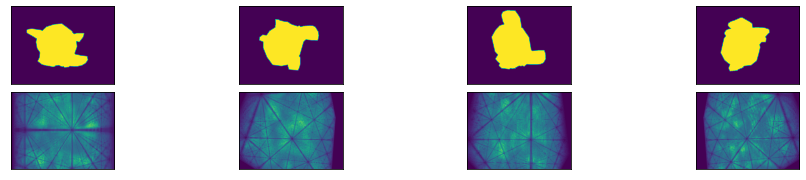

*** *** *** *** *** *** *** *** *** *** *** *** ***
Saving...
Saving .dae file...
Iteration: 101 Loss: 0.7775330


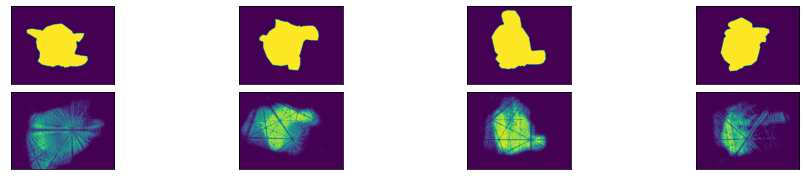

*** *** *** *** *** *** *** *** *** *** *** *** ***
Iteration: 201 Loss: 0.7600532


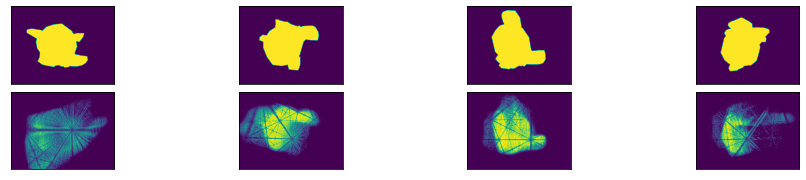

*** *** *** *** *** *** *** *** *** *** *** *** ***
Saving...
Saving .dae file...
Iteration: 301 Loss: 0.7524875


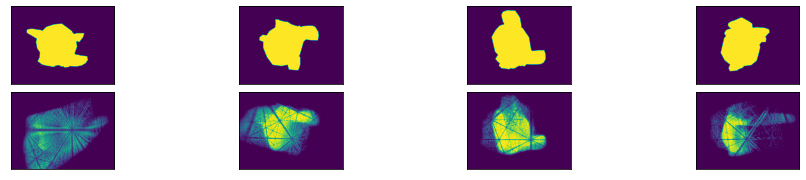

*** *** *** *** *** *** *** *** *** *** *** *** ***
Iteration: 401 Loss: 0.7486878


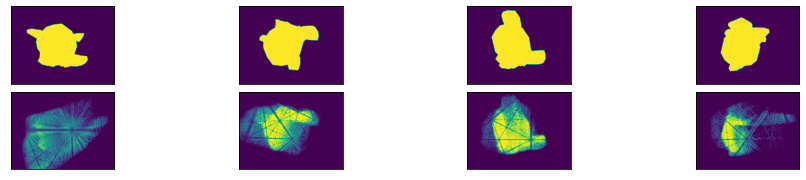

*** *** *** *** *** *** *** *** *** *** *** *** ***
Saving...
Saving .dae file...
Iteration: 501 Loss: 0.7467793


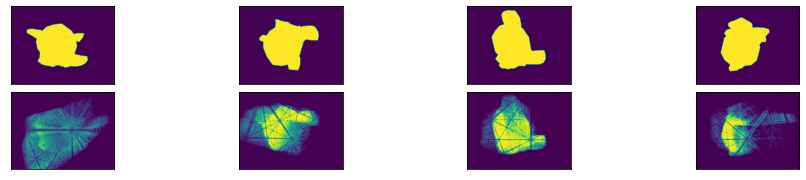

*** *** *** *** *** *** *** *** *** *** *** *** ***
Iteration: 601 Loss: 0.7449394


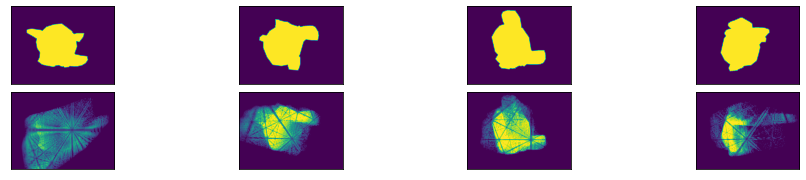

*** *** *** *** *** *** *** *** *** *** *** *** ***
Saving...
Saving .dae file...
Iteration: 701 Loss: 0.7414011


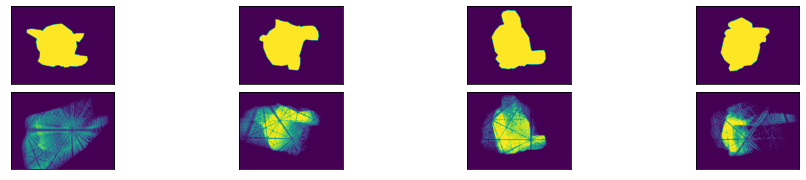

*** *** *** *** *** *** *** *** *** *** *** *** ***
Iteration: 801 Loss: 0.7414475


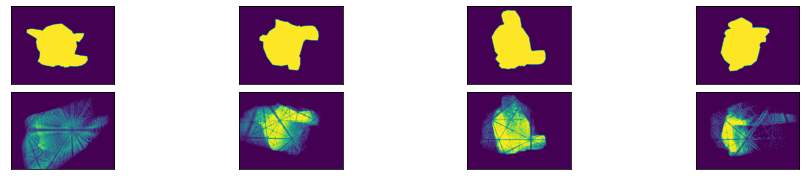

*** *** *** *** *** *** *** *** *** *** *** *** ***
Saving...
Saving .dae file...
Iteration: 901 Loss: 0.7415369


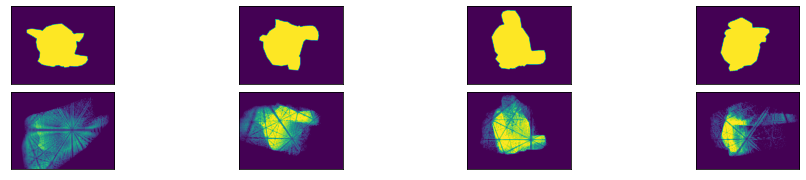

*** *** *** *** *** *** *** *** *** *** *** *** ***
Iteration: 1001 Loss: 0.7407311


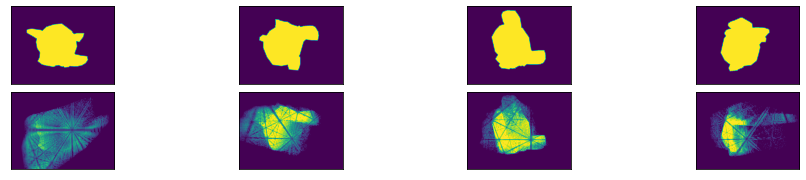

*** *** *** *** *** *** *** *** *** *** *** *** ***
Saving...
Saving .dae file...
Iteration: 1101 Loss: 0.7404904


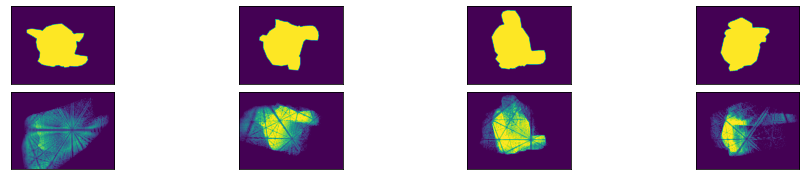

*** *** *** *** *** *** *** *** *** *** *** *** ***
Iteration: 1201 Loss: 0.7531513


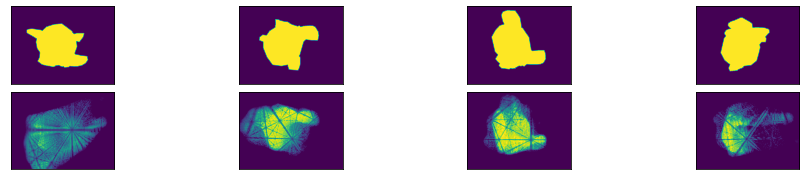

*** *** *** *** *** *** *** *** *** *** *** *** ***
Saving...
Saving .dae file...
Iteration: 1301 Loss: 0.7419159


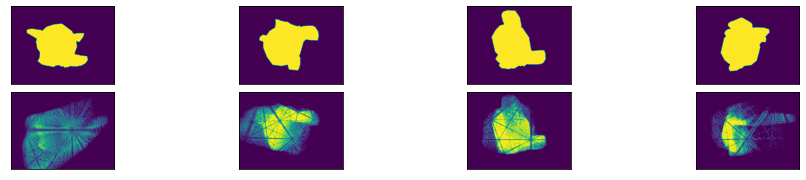

*** *** *** *** *** *** *** *** *** *** *** *** ***
Iteration: 1401 Loss: 0.7405034


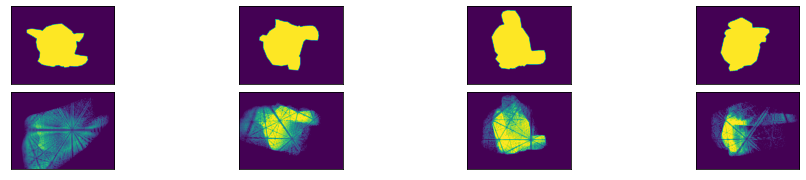

*** *** *** *** *** *** *** *** *** *** *** *** ***
Saving...
Saving .dae file...
Iteration: 1501 Loss: 0.7383392


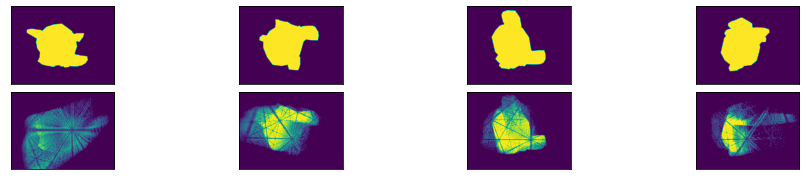

*** *** *** *** *** *** *** *** *** *** *** *** ***
Iteration: 1601 Loss: 0.7388422


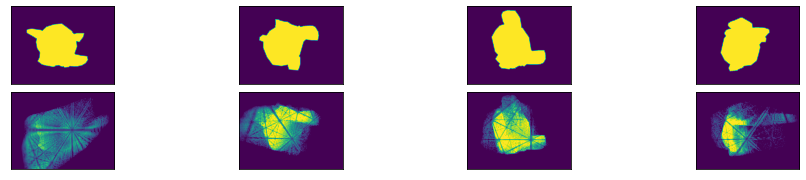

*** *** *** *** *** *** *** *** *** *** *** *** ***
Saving...
Saving .dae file...
Iteration: 1701 Loss: 0.7391987


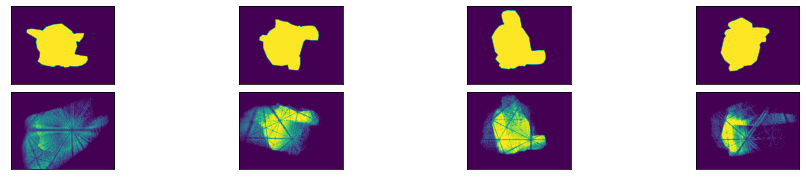

*** *** *** *** *** *** *** *** *** *** *** *** ***


In [ ]:
for i in range(iterations):
    optimizer.zero_grad()

    # forward
    y = model(z) # output voxel grid

    # 2D PROJECTIONS
    proj = project_3d_voxel_grid_to_2d_camera_array_TORCH(y[0, 0].flatten(), M, [640, 480]) # project the voxel grid back onto the camera views
    
    # loss
    loss_ = 0
    for j, p in enumerate(proj):
      loss_ += loss(p.T, torch.Tensor(silhouettes[:, :, j])) # calculate and add the loss between the projected silhouettes and the ground truth silhouettes
    losses.append(loss_.item())

    # backward
    loss_.backward()

    # step
    optimizer.step()

    if i % print_every == 0:
        print('Iteration: {} Loss: {:.07f}'.format(i + 1, losses[-1]))
        generate_all_projections(i, y[0, 0].flatten(), silhouettes, M, [640, 480], no_of_projections=4)
        print("*** *** *** *** *** *** *** *** *** *** *** *** ***")

    if i % save_every == 0:
        print("Saving...")
        np.save(EXPERIMENT_DIR + "monkey_voxel_EXP_" + str(NUMBER_OF_VIEWS_FOR_EXPERIMENT) + "_ITER_" + str(i) + "_90_90_90.npy", y.cpu().detach().numpy()[0][0])

        print("Saving .dae file...")
        # Extract the 0-isosurface
        vertices, triangles = mcubes.marching_cubes(y.cpu().detach().numpy()[0][0], 0.98)

        # Export the result to sphere.dae
        mcubes.export_mesh(vertices, triangles, EXPERIMENT_DIR + "monkey_EXP_" + str(NUMBER_OF_VIEWS_FOR_EXPERIMENT) + "_ITER_" + str(i) + ".dae", "cube_" + str(i))

In [ ]:
np.save(EXPERIMENT_DIR + "cube_voxel_EXP_" + str(NUMBER_OF_VIEWS_FOR_EXPERIMENT) + "_ITER_" + str(iterations) + "_90_90_90.npy", y.cpu().detach().numpy()[0][0])

In [ ]:
!zip -r torus_DVH_exp_32.zip "/content/EXPERIMENTS_3/torus/exp_118"

  adding: content/EXPERIMENTS_3/torus/exp_118/ (stored 0%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/ (stored 0%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/torus_proj_EXP_118_ITER_1500.png (deflated 2%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/torus_proj_EXP_118_ITER_200.png (deflated 2%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/torus_proj_EXP_118_ITER_900.png (deflated 2%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/torus_proj_EXP_118_ITER_1600.png (deflated 2%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/torus_proj_EXP_118_ITER_300.png (deflated 2%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/torus_proj_EXP_118_ITER_0.png (deflated 1%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/torus_proj_EXP_118_ITER_1800.png (deflated 2%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/torus_proj_EXP_118_ITER_100.png (deflated 2%)
  adding: content/EXPERIMENTS_3/torus/exp_118/images/torus_proj_EXP_118_ITER_400.p

In [ ]:
# Extract the 0-isosurface
vertices, triangles = mcubes.marching_cubes(y.cpu().detach().numpy()[0][0], 0.98)

# Export the result to sphere.dae
mcubes.export_mesh(vertices, triangles, EXPERIMENT_DIR + "cube_EXP_" + str(NUMBER_OF_VIEWS_FOR_EXPERIMENT) + "_ITER_" + str(iterations) + ".dae", "cube_" + str(i))

FileNotFoundError: ignored

# Misc.

In [ ]:
out_ = model(z)[0, 0, :, :, :]

In [ ]:
print(torch.max(out_))

tensor(4.2729, grad_fn=<MaxBackward1>)


In [ ]:
np.save("voxel_out_2.3341000_10000_90_90_90.npy", out_.cpu().detach().numpy())

In [ ]:
print(out_.shape)

NameError: ignored

In [ ]:
x = x.transpose(2, 0, 1).astype(int)

NameError: ignored

In [ ]:
for i in range(128):
  out = x_masked[:, :, :].cpu().detach()[:, :, i]
  out = np.array(out.reshape((128, 128))*255, np.uint8)
  # print(np.unique(out))
  plt.figure()
  plt.imshow(out > 100)
  plt.show()

In [ ]:
for i in range(128):
  out = out_.cpu().detach()[:, :, i]
  out = np.array(out.reshape((128, 128))*255, np.uint8)
  # print(np.unique(out))
  plt.figure()
  # print(out[0, 0])
  plt.imshow(out > 20)
  plt.show()

In [ ]:
out_ = out_.cpu().detach().numpy()
print(out_)
out_[np.where(out_ > 0.5)] = True
out_[np.where(out_ <= 0.5)] = False

In [ ]:
z_ = x.cpu().detach().numpy()
print(z_)
z_[np.where(z_ > 0.5)] = True
z_[np.where(z_ <= 0.5)] = False
z_ = np.array(z_, np.uint8)

In [ ]:
print(z_[0, 0, :, :, :].shape)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
N1 = 128
N2 = 128
N3 = 128

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.voxels(np.array(out_.transpose(0, 2, 1), dtype=np.int8), edgecolor="k")

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
N1 = 128
N2 = 128
N3 = 128

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.voxels(US.cpu().numpy().transpose(0, 2, 1), edgecolors="m")

plt.show()

In [ ]:
print(np.where((out > 0.5 and US.cpu().numpy() < 0.5)))

In [ ]:
US = nn.Upsample(scale_factor=(4, 4, 4))((x.reshape((1, 1, 32, 32, 32))).float())[0, 0, :, :, :]

In [ ]:
print(US.shape)

In [ ]:
import bv
with open('bv/chair.binvox', 'rb') as f:
  model_ = binvox_rw.read_as_3d_array(f)

In [ ]:
model_.data = out_.astype(int)

In [ ]:
def write(voxel_model, fp):
  """ Write binary binvox format.

  Note that when saving a model in sparse (coordinate) format, it is first
  converted to dense format.

  Doesn't check if the model is 'sane'.

  """
  if voxel_model.data.ndim==2:
      # TODO avoid conversion to dense
      dense_voxel_data = sparse_to_dense(voxel_model.data, voxel_model.dims)
  else:
      dense_voxel_data = voxel_model.data
  print('fp : ', fp)
  with open(fp, 'w') as fw:
      fw.write('#binvox 1\n')
      fw.write('dim '+' '.join(map(str, voxel_model.dims))+'\n')
      fw.write('translate '+' '.join(map(str, voxel_model.translate))+'\n')
      fw.write('scale '+str(voxel_model.scale)+'\n')
      fw.write('data\n')
      if not voxel_model.axis_order in ('xzy', 'xyz'):
        raise ValueError('Unsupported voxel model axis order')

      if voxel_model.axis_order=='xzy':
        voxels_flat = dense_voxel_data.flatten()
      elif voxel_model.axis_order=='xyz':
        voxels_flat = np.transpose(dense_voxel_data, (0, 2, 1)).flatten()

  # keep a sort of state machine for writing run length encoding
      state = voxels_flat[0]
      ctr = 0
      for c in voxels_flat:
        if c==state:
            ctr += 1
          # if ctr hits max, dump
            if ctr==255:
                fw.write(chr(state))
                fw.write(chr(ctr))
                ctr = 0
        else:
            # if switch state, dump
            fw.write(chr(state))
            fw.write(chr(ctr))
            state = c
            ctr = 1
  # flush out remainders
        if ctr > 0:
          fw.write(chr(state))
          fw.write(chr(ctr))

write(model_, "bv/test_2.binvox")